In [1]:
# !conda install -c pyviz holoviews bokeh

In [2]:
# ! pip install -U scikit-learn

In [3]:
# ! pip install bokeh

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from textblob import TextBlob

from sklearn import metrics, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from helper_functions import *

from sklearn.model_selection import train_test_split

In [6]:
accuracy_res = []
precision_res = []
recall_res = []
f1_res = []
hamming_res = []
mean_irlbls = []
auc_list = []
labels = []

def addValuesToResults(result):   
   accuracy_res.append(result['accuracy'])
   precision_res.append(result['precision'])
   recall_res.append(result['recall'])
   f1_res.append(result['f1_score'])
   hamming_res.append(result['hamming_loss'])

# Data Exploratory Analysis

In [7]:
# import tweet processing module
from TweetProcessor import TweetProcessor as tp
tweet_processor = tp.TweetProcessor()

In [8]:
# import data
emo_train_df = pd.read_csv('data/2018-E-c-En-train.txt', sep='\t')
emo_test_df = pd.read_csv('data/2018-E-c-En-test-gold.txt', sep='\t')
print(emo_train_df.shape)
emo_train_df.head()

(6838, 13)


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [9]:
feelings = emo_train_df.columns[2:]#['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
emo_train_df[feelings].sum().sort_values()

trust            357
surprise         361
love             700
pessimism        795
anticipation     978
fear            1242
optimism        1984
sadness         2008
joy             2477
anger           2544
disgust         2602
dtype: int64

(6838, 13) 2.902


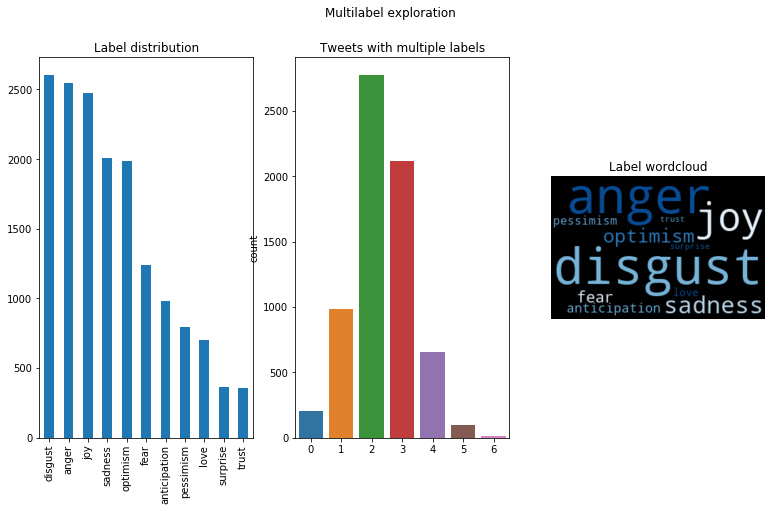

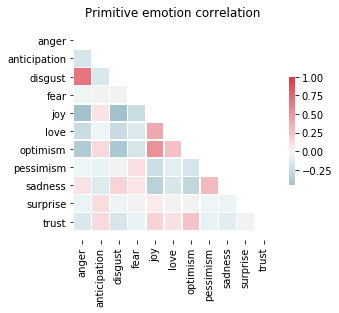

In [10]:
mean_irlbls.append(mean_irlbl(emo_train_df, feelings))
print(emo_train_df.shape, mean_irlbls[-1]) 
multilabel_visualization(emo_train_df[feelings].values, feelings)

According to the Label Distribution plot there is class imbalance to our dataset
We classify the emotions using ideal partition, a KMeans clustering method educated by silhouette metricclassification

In [11]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(emo_train_df, feelings)
n_emo_clusters, emo_cluster_dict

(4,
 {0: Index(['anticipation', 'surprise', 'trust'], dtype='object'),
  1: Index(['anger', 'disgust'], dtype='object'),
  2: Index(['joy', 'love', 'optimism'], dtype='object'),
  3: Index(['fear', 'pessimism', 'sadness'], dtype='object')})

# Class Imbalance

Traditional resampling techniques do not work in multilabel data
Explore the following methods that deal with **class imbalance**:
1. Up-sample Minority Class
2. Down-sample Majority Class
3. Easy Ensemble
4. Synthetic Minority Oversampling TEchnique - SMOTE


In [12]:
# ! pip install -U imbalanced-learn

#### Preprocessing - feature selection

In [13]:
# preprocessing test and training sets
combined_df = pd.concat([emo_train_df, emo_test_df])
combined_df['tokenized_features'] = combined_df['Tweet'].apply(tweet_processor.tweet_pipeline)
X = combined_df['tokenized_features'].apply(lambda x: ' '.join(x)).values

# TF-IDF text features
vectorizer = tweet_processor.tfidf_vectorizer(X)
X_tfidf = vectorizer.transform(X)

# TF-IDF emoji features
vectorizer = tweet_processor.emoji_vectorizer(X)
X_emoji = vectorizer.transform(X)

# Combine features
X_combined = np.hstack((X_tfidf.toarray(), X_emoji.toarray()))

emo_train_df['feature_vector'] = X_combined[:emo_train_df.shape[0]].tolist()
emo_test_df['feature_vector'] = X_combined[-emo_test_df.shape[0]:].tolist()
emo_train_df['feature_vector'].shape, emo_test_df['feature_vector'].shape

((6838,), (3259,))

### Test various over sampling techniques

* Random sampling of the weakest labels
* LP oversamping of weakest labels (LP-ROS)
* Random oversampling according to KMeans clustering
* Multilabel SMOTE oversampling

####  Random over sampling of the weakest labels

Weak are considered the labels with that are populated below the median label count

In [14]:
majority_class = emo_train_df[feelings].sum().sort_values(ascending=False).index[0]
majority_class_pop = emo_train_df[feelings].sum().sort_values(ascending=False)[0]
target_pop = np.median(emo_train_df[feelings].sum())

weak_labels = feelings[emo_train_df[feelings].sum()<=target_pop].values.tolist()
weak_labels

['anticipation', 'fear', 'love', 'pessimism', 'surprise', 'trust']

In [15]:
df_list = []
for label in weak_labels:
   label_indices = emo_train_df.loc[emo_train_df[label]==1, :].index.values
   over_sampled_data = np.random.choice(label_indices, int(target_pop))
   df_list.append(emo_train_df.loc[over_sampled_data, feelings.values.tolist()+['feature_vector']])
   
resampled_df = pd.concat(df_list)

In [16]:
x_train = np.vstack(resampled_df['feature_vector'].values)
x_test = np.vstack(emo_test_df['feature_vector'].values)
y_train = resampled_df[feelings].values
y_test = emo_test_df[feelings].values
print(x_train.shape, y_train.shape, x_test.shape)

(7452, 4824) (7452, 11) (3259, 4824)


In [17]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(resampled_df, feelings)
n_emo_clusters, emo_cluster_dict

(3,
 {0: Index(['anger', 'disgust', 'fear', 'pessimism', 'sadness'], dtype='object'),
  1: Index(['joy', 'love', 'optimism', 'trust'], dtype='object'),
  2: Index(['anticipation', 'surprise'], dtype='object')})

1.712


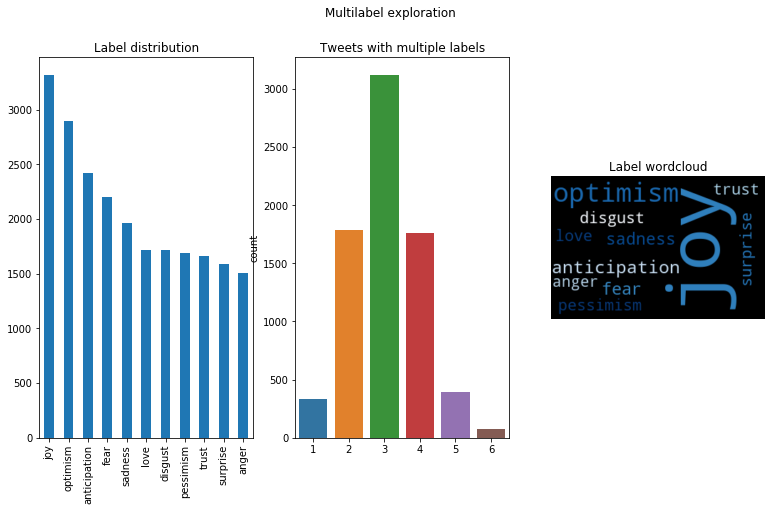

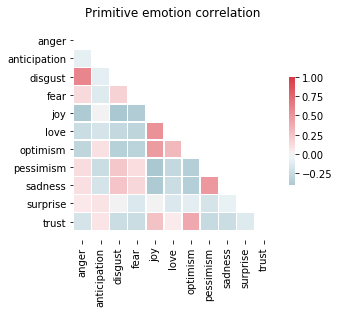

In [18]:
df = pd.DataFrame(y_train, columns=feelings)
mean_irlbls.append(mean_irlbl(df, feelings))
print(mean_irlbls[-1])   
multilabel_visualization(df[feelings].values, feelings)

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

print("")
print("Starting classifier...")
print("")
start = datetime.now()

pipeline = Pipeline([
                ('clf', OneVsRestClassifier(BernoulliNB(class_prior=None)))
            ])

parameters = [{
            'clf__estimator__alpha': (0.5, 0.7, 1),
            }]

grid_search_cv = GridSearchCV(pipeline, 
                              parameters, 
                              cv=2,
                              verbose=2,
                              n_jobs=-1)
grid_search_cv.fit(x_train, y_train)
best_clf = grid_search_cv.best_estimator_

print('Finished training in : ', datetime.now()-start) 

y_pred = best_clf.predict(x_test)

start = datetime.now()
results = multilabel_evaluation(y_pred, y_test)
addValuesToResults(results)
print(results)
print('Finished classification in : ', datetime.now()-start) 


Starting classifier...

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   16.1s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   16.2s finished


Finished training in :  0:00:23.060157
{'accuracy': 0.782, 'precision': 0.454, 'recall': 0.436, 'f1_score': 0.445, 'hamming_loss': 0.218}
Finished classification in :  0:00:00.013246


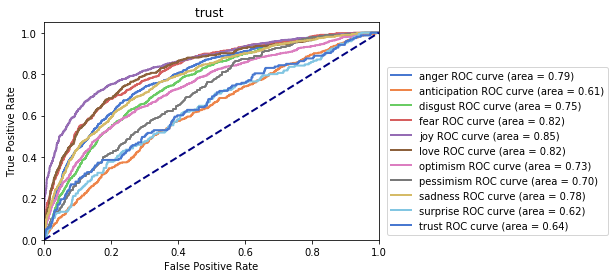

In [20]:
auc_list.append(plot_roc(y_test, best_clf.predict_proba(x_test), feelings.values))

In [21]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(y_pred, feelings)
n_emo_clusters, emo_cluster_dict

(3,
 {0: Index(['anger', 'disgust', 'fear', 'pessimism', 'sadness'], dtype='object'),
  1: Index(['joy', 'love', 'optimism', 'trust'], dtype='object'),
  2: Index(['anticipation', 'surprise'], dtype='object')})

#### LP oversamping of weakest labels


In [22]:
df_list = []
for label in weak_labels:
   df_list.append(emo_train_df.loc[emo_train_df[label]==1, :])

resampled_df = pd.concat(df_list)

In [23]:
from skmultilearn.problem_transform import LabelPowerset
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

lp = LabelPowerset()

x_train = np.vstack(resampled_df['feature_vector'].values)
y_train = resampled_df[feelings].values

y_train_lp = lp.transform(y_train)

# Random oversampling
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_sample(x_train, y_train_lp)
y_train_resampled = lp.inverse_transform(y_resampled)

In [24]:
x_train = X_resampled
x_test = np.vstack(emo_test_df['feature_vector'].values)
y_train = y_train_resampled.toarray()
y_test = emo_test_df[feelings].values
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(type(x_train), type(y_train), type(x_test), type(y_test))

(91476, 4824) (91476, 11) (3259, 4824) (3259, 11)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [25]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(y_train, feelings)
n_emo_clusters, emo_cluster_dict

(2,
 {0: Index(['anger', 'anticipation', 'disgust', 'fear', 'pessimism', 'sadness',
         'surprise'],
        dtype='object'),
  1: Index(['joy', 'love', 'optimism', 'trust'], dtype='object')})

1.385


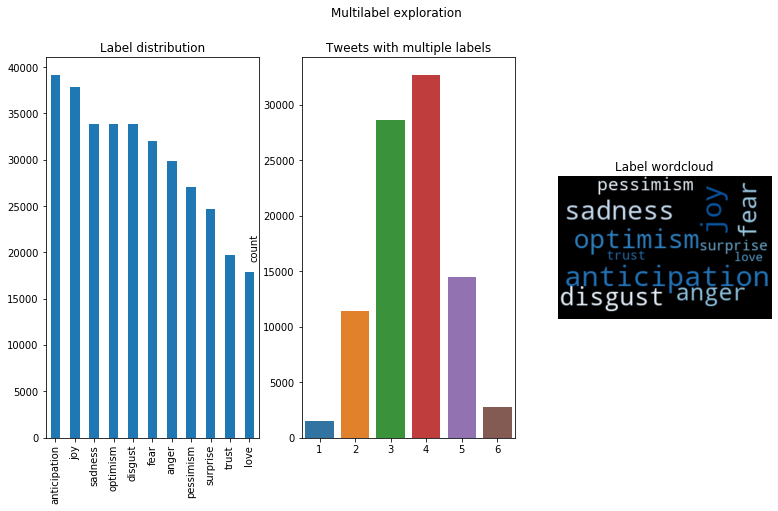

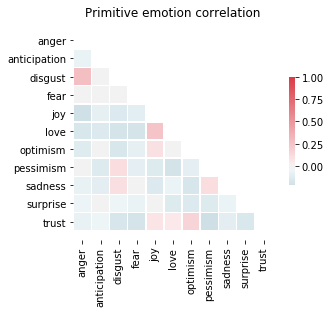

In [26]:
df = pd.DataFrame(y_train, columns=feelings)
mean_irlbls.append(mean_irlbl(df, feelings))
print(mean_irlbls[-1])   
multilabel_visualization(df[feelings].values, feelings)

In [27]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

print("")
print("Starting classifier...")
print("")
start = datetime.now()

pipeline = Pipeline([
                ('clf', OneVsRestClassifier(BernoulliNB(class_prior=None, alpha=0.5)))
            ])

parameters = [{
#             'clf__estimator__alpha': (0.5, 0.7, 1),
            }]

grid_search_cv = GridSearchCV(pipeline, 
                              parameters, 
                              cv=2,
                              verbose=10)

grid_search_cv.fit(x_train, y_train)
best_clf = grid_search_cv.best_estimator_

print('Finished training in : ', datetime.now()-start) 

y_pred = best_clf.predict(x_test)
start = datetime.now()
results = multilabel_evaluation(y_pred, y_test)
addValuesToResults(results)
print(results)
print('Finished classification in : ', datetime.now()-start) 


Starting classifier...

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.024, total= 1.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] .................................... , score=0.020, total= 1.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished


Finished training in :  0:04:04.179943
{'accuracy': 0.746, 'precision': 0.398, 'recall': 0.375, 'f1_score': 0.386, 'hamming_loss': 0.254}
Finished classification in :  0:00:00.011073


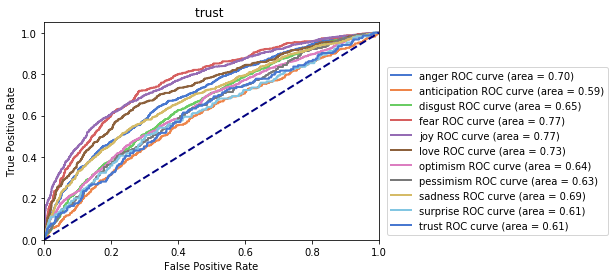

In [28]:
auc_list.append(plot_roc(y_test, best_clf.predict_proba(x_test), feelings.values))

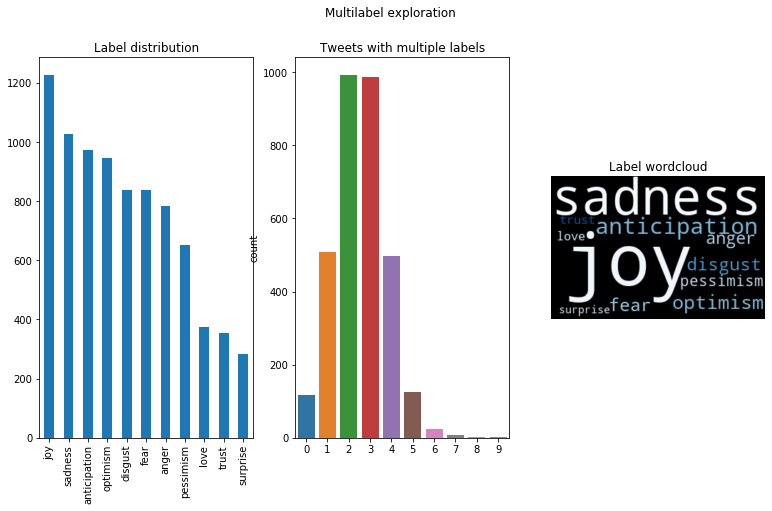

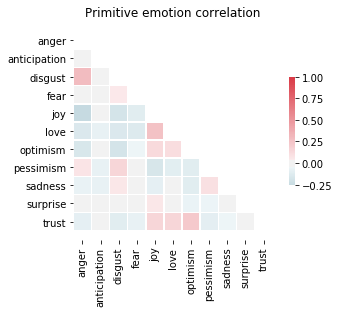

In [29]:
multilabel_visualization(y_pred, feelings)

In [30]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(y_pred, feelings)
n_emo_clusters, emo_cluster_dict

(3,
 {0: Index(['anticipation', 'surprise'], dtype='object'),
  1: Index(['joy', 'love', 'optimism', 'trust'], dtype='object'),
  2: Index(['anger', 'disgust', 'fear', 'pessimism', 'sadness'], dtype='object')})

#### Random oversampling  according to KMeans clustering


In [31]:
majority_class = emo_train_df[feelings].sum().sort_values(ascending=False).index[0]
majority_class_pop = emo_train_df[feelings].sum().sort_values(ascending=False)[0]
target_pop = np.median(emo_train_df[feelings].sum())

In [32]:
from sklearn.cluster import KMeans
X = emo_train_df[feelings].corr().values
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

# create clustering dictionay: cluster:correlated emotions
clustering = {i:feelings[kmeans.labels_==i] for i in set(kmeans.labels_)}
clustering

{0: Index(['anticipation', 'surprise', 'trust'], dtype='object'),
 1: Index(['anger', 'disgust'], dtype='object'),
 2: Index(['joy', 'love', 'optimism'], dtype='object'),
 3: Index(['fear', 'pessimism', 'sadness'], dtype='object')}

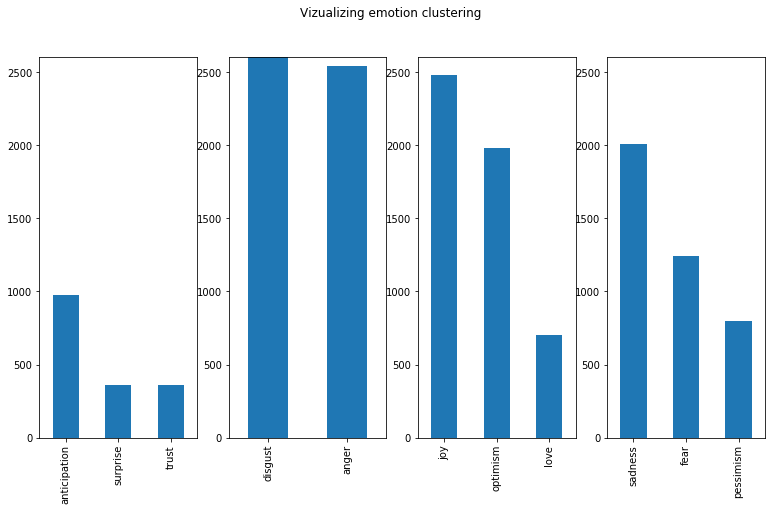

In [33]:
# Visualize clabel correlation clustering
fig, axes = plt.subplots(1, 4, figsize=(13,7))
fig.suptitle('Vizualizing emotion clustering')
for c,ax in zip(set(kmeans.labels_), axes):
   emo_train_df[clustering[c]].sum().sort_values(ascending=False).plot(kind='bar', ax=ax)
   ax.set_ylim([0, majority_class_pop])
plt.show()

In [34]:
df_list = []
for label in clustering[0]:
   label_indices = emo_train_df.loc[emo_train_df[label]==1, :].index.values
   over_sampled_data = np.random.choice(label_indices, int(target_pop))
   df_list.append(emo_train_df.loc[over_sampled_data, feelings.values.tolist()+['feature_vector']])

for label in clustering[3]:
   label_indices = emo_train_df.loc[emo_train_df[label]==1, :].index.values
   over_sampled_data = np.random.choice(label_indices, int(target_pop))
   df_list.append(emo_train_df.loc[over_sampled_data, feelings.values.tolist()+['feature_vector']])   

resampled_df = pd.concat(df_list)

In [35]:
x_train = np.vstack(resampled_df['feature_vector'].values)
x_test = np.vstack(emo_test_df['feature_vector'].values)
y_train = resampled_df[feelings].values
y_test = emo_test_df[feelings].values
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(7452, 4824) (7452, 11) (3259, 4824) (3259, 11)


In [36]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(y_train, feelings)
n_emo_clusters, emo_cluster_dict

(2,
 {0: Index(['anger', 'disgust', 'fear', 'pessimism', 'sadness'], dtype='object'),
  1: Index(['anticipation', 'joy', 'love', 'optimism', 'surprise', 'trust'], dtype='object')})

1.862


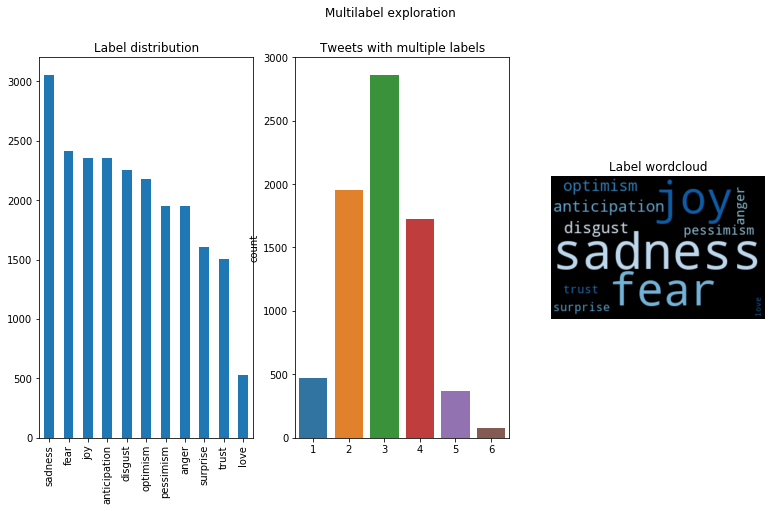

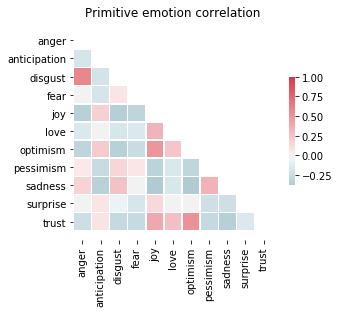

In [37]:
df = pd.DataFrame(y_train, columns=feelings)
mean_irlbls.append(mean_irlbl(df, feelings))
print(mean_irlbls[-1])   
multilabel_visualization(df[feelings].values, feelings)

In [38]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline


print("")
print("Starting classifier...")
print("")
start = datetime.now()

pipeline = Pipeline([
                ('clf', OneVsRestClassifier(BernoulliNB(class_prior=None)))
            ])

parameters = [{
            'clf__estimator__alpha': (0.5, 0.7, 1),
            }]

grid_search_cv = GridSearchCV(pipeline, 
                              parameters, 
                              cv=2,
                              verbose=2,
                              n_jobs=-1)
grid_search_cv.fit(x_train, y_train)
best_clf = grid_search_cv.best_estimator_

print('Finished training in : ', datetime.now()-start) 

y_pred = best_clf.predict(x_test)
start = datetime.now()
results = multilabel_evaluation(y_pred, y_test)
addValuesToResults(results)
print(results)
print('Finished classification in : ', datetime.now()-start) 



Starting classifier...

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   13.7s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   14.0s finished


Finished training in :  0:00:20.824656
{'accuracy': 0.778, 'precision': 0.437, 'recall': 0.443, 'f1_score': 0.44, 'hamming_loss': 0.222}
Finished classification in :  0:00:00.007444


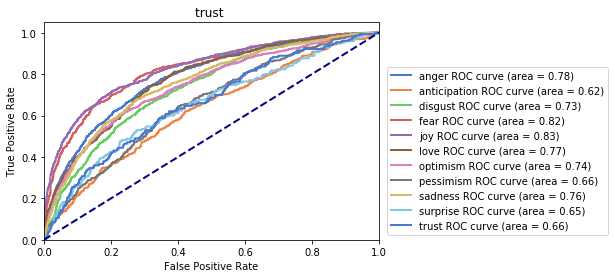

In [39]:
auc_list.append(plot_roc(y_test, best_clf.predict_proba(x_test), feelings.values))

In [40]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(y_pred, feelings)
n_emo_clusters, emo_cluster_dict

(2,
 {0: Index(['anger', 'disgust', 'fear', 'pessimism', 'sadness'], dtype='object'),
  1: Index(['anticipation', 'joy', 'love', 'optimism', 'surprise', 'trust'], dtype='object')})

### Multilabel SMOTE

Steps for multilabel SMOTE:
* minority label selection
* nearest kneighbor search
* featureset generation: selected one of the neighbors, the set of  features for the synthetic instance is obtained through interpolation techniques (intersection, union, ranking)
* synthetic labelset production
* merge synthetic and original datasets
* execute classification and evaluation

In [41]:
def mll_smote(df, labels, method, k=5):
   import random
   # find minority bags
   majority_class_pop = df[labels].sum().max()
   minbag_lbl = labels[(majority_class_pop/df[labels].sum())>mean_irlbl(df, labels)].values.tolist()
   
   synth_samples = []
   synth_labels = []
   for label in minbag_lbl:
      minbag = df[df[label]==1]
      minbag_feat = np.vstack((minbag['feature_vector'].values))
      print('Performing SMOTE on label: ', label)
      for i, sample in enumerate(minbag_feat):
         #
         # find neighbors for k
         #
         neighbors = np.argsort(np.sqrt(np.sum((minbag_feat-sample)**2, axis=1)))[1:6]
         neigh_i = np.random.choice(neighbors, 1, replace=False)[0]
         refNeigh = minbag_feat[neigh_i]
         sample_label = minbag.iloc[i][labels].values
         refNeigh_label = minbag.iloc[neigh_i][labels].values
         #
         # create synthetic sample
         # 
         offset = (refNeigh-sample)*random.random()
         synth_sample = sample + offset
         #
         # create synthetic label
         #
         if method=='intersection':         
            synth_label = np.logical_and(sample_label, refNeigh_label) * 1
         elif method=='union':  
            synth_label = np.logical_or(sample_label, refNeigh_label) * 1
         elif method=='ranking':
            synth_label = (minbag.iloc[np.append(neighbors, i)][labels].sum() >= (k+1)/2) * 1
         else:
            raise ValueError("Invalid method name: '%s'\nThe 'method' must be one of 'intersection', 'union', or 'ranking'." % method)

         # collect the synthetic sample
         synth_samples.append(synth_sample)
         synth_labels.append(synth_label)
         
   synth_samples = np.asarray(synth_samples, dtype=np.float64)
   synth_labels = np.asarray(synth_labels, dtype=np.float64)
   return synth_samples, synth_labels

SMOTE method: `intersection`

In [42]:
synth_samples, synth_labels = mll_smote(emo_train_df, feelings, 'intersection')
synth_samples.shape, synth_labels.shape

Performing SMOTE on label:  love
Performing SMOTE on label:  pessimism
Performing SMOTE on label:  surprise
Performing SMOTE on label:  trust


((2213, 4824), (2213, 11))

Merge synthetic and regular data

In [43]:
x_train = np.concatenate((np.vstack(emo_train_df['feature_vector'].values), synth_samples))                    
x_test = np.vstack(emo_test_df['feature_vector'].values)
y_train = np.concatenate((emo_train_df[feelings].values, synth_labels))
y_test = emo_test_df[feelings].values

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(9051, 4824) (9051, 11) (3259, 4824) (3259, 11)


In [44]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(y_train, feelings)
n_emo_clusters, emo_cluster_dict

(4,
 {0: Index(['anger', 'disgust'], dtype='object'),
  1: Index(['anticipation', 'surprise', 'trust'], dtype='object'),
  2: Index(['joy', 'love', 'optimism'], dtype='object'),
  3: Index(['fear', 'pessimism', 'sadness'], dtype='object')})

2.287


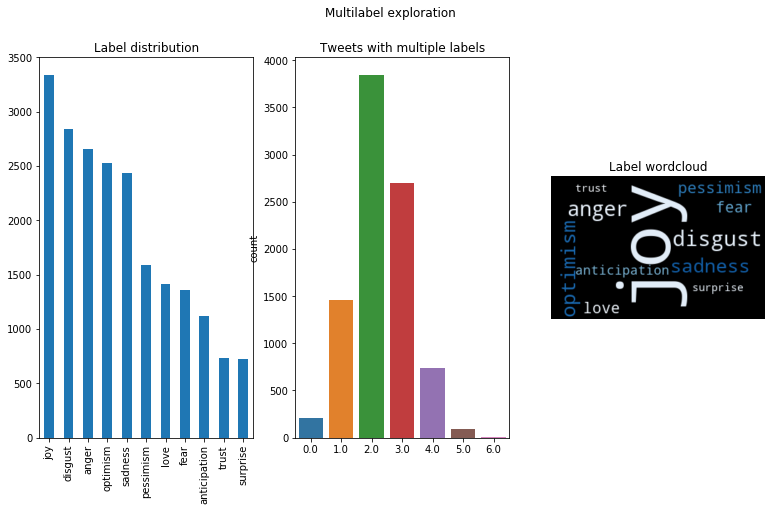

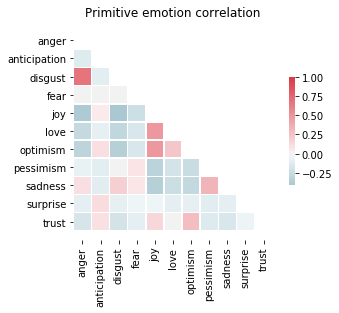

In [45]:
smote_df = pd.DataFrame(y_train, columns=feelings)
mean_irlbls.append(mean_irlbl(smote_df, feelings))
print(mean_irlbls[-1])   
multilabel_visualization(smote_df[feelings].values, feelings)

Classification

In [46]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

print("")
print("Starting classifier...")
print("")
start = datetime.now()

pipeline = Pipeline([
                ('clf', OneVsRestClassifier(BernoulliNB(class_prior=None)))
            ])

parameters = [{
            'clf__estimator__alpha': (0.5, 0.7, 1),
            }]

grid_search_cv = GridSearchCV(pipeline, 
                              parameters, 
                              cv=2,
                              verbose=2,
                              n_jobs=-1)
grid_search_cv.fit(x_train, y_train)
best_clf = grid_search_cv.best_estimator_

print('Finished training in : ', datetime.now()-start) 

y_pred = best_clf.predict(x_test)
start = datetime.now()
results = multilabel_evaluation(y_pred, y_test)
addValuesToResults(results)
print(results)
print('Finished classification in : ', datetime.now()-start) 



Starting classifier...

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   17.7s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   17.7s finished


Finished training in :  0:00:25.765668
{'accuracy': 0.835, 'precision': 0.373, 'recall': 0.532, 'f1_score': 0.439, 'hamming_loss': 0.165}
Finished classification in :  0:00:00.009828


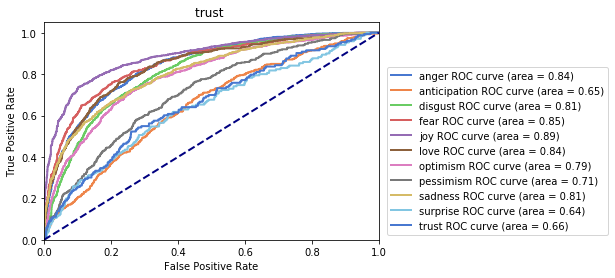

In [47]:
auc_list.append(plot_roc(y_test, best_clf.predict_proba(x_test), feelings.values))

In [48]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(y_pred, feelings)
n_emo_clusters, emo_cluster_dict

(4,
 {0: Index(['fear', 'pessimism', 'sadness'], dtype='object'),
  1: Index(['anticipation', 'surprise', 'trust'], dtype='object'),
  2: Index(['joy', 'love', 'optimism'], dtype='object'),
  3: Index(['anger', 'disgust'], dtype='object')})

SMOTE method: `union`

In [49]:
synth_samples, synth_labels = mll_smote(emo_train_df, feelings, 'union')
synth_samples.shape, synth_labels.shape

Performing SMOTE on label:  love
Performing SMOTE on label:  pessimism
Performing SMOTE on label:  surprise
Performing SMOTE on label:  trust


((2213, 4824), (2213, 11))

In [50]:
x_train = np.concatenate((np.vstack(emo_train_df['feature_vector'].values), synth_samples))                    
x_test = np.vstack(emo_test_df['feature_vector'].values)
y_train = np.concatenate((emo_train_df[feelings].values, synth_labels))
y_test = emo_test_df[feelings].values

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(9051, 4824) (9051, 11) (3259, 4824) (3259, 11)


In [51]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(y_train, feelings)
n_emo_clusters, emo_cluster_dict

(3,
 {0: Index(['anger', 'disgust', 'fear', 'pessimism', 'sadness'], dtype='object'),
  1: Index(['joy', 'love', 'optimism', 'trust'], dtype='object'),
  2: Index(['anticipation', 'surprise'], dtype='object')})

2.117


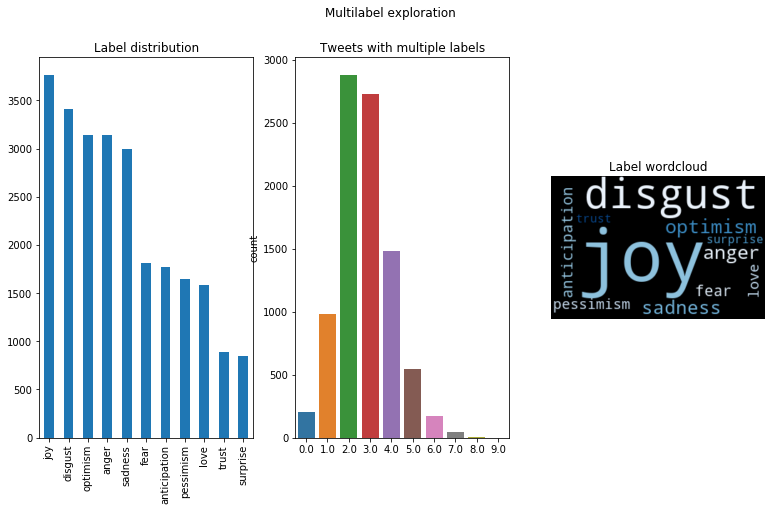

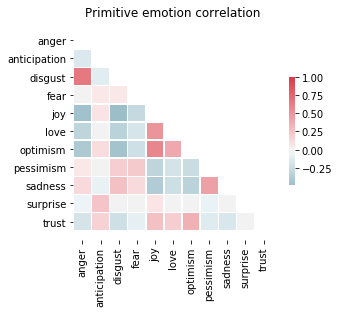

In [52]:
smote_df = pd.DataFrame(y_train, columns=feelings)
mean_irlbls.append(mean_irlbl(smote_df, feelings))
print(mean_irlbls[-1])   
multilabel_visualization(smote_df[feelings].values, feelings)

In [53]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

print("")
print("Starting classifier...")
print("")
start = datetime.now()

pipeline = Pipeline([
                ('clf', OneVsRestClassifier(BernoulliNB(class_prior=None)))
            ])

parameters = [{
            'clf__estimator__alpha': (0.5, 0.7, 1),
            }]

grid_search_cv = GridSearchCV(pipeline, 
                              parameters, 
                              cv=2,
                              verbose=2,
                              n_jobs=-1)
grid_search_cv.fit(x_train, y_train)
best_clf = grid_search_cv.best_estimator_

print('Finished training in : ', datetime.now()-start) 

y_pred = best_clf.predict(x_test)
start = datetime.now()
results = multilabel_evaluation(y_pred, y_test)
addValuesToResults(results)
print(results)
print('Finished classification in : ', datetime.now()-start) 


Starting classifier...

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   16.0s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   16.4s finished


Finished training in :  0:00:24.203777
{'accuracy': 0.832, 'precision': 0.429, 'recall': 0.503, 'f1_score': 0.463, 'hamming_loss': 0.168}
Finished classification in :  0:00:00.008920


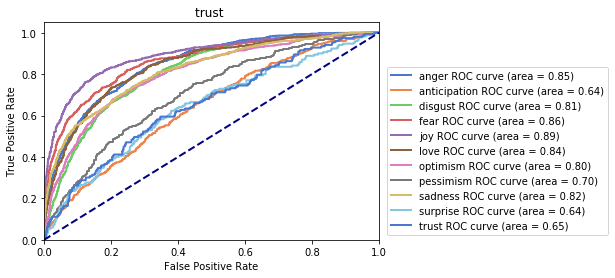

In [54]:
auc_list.append(plot_roc(y_test, best_clf.predict_proba(x_test), feelings.values))

In [55]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(y_pred, feelings)
n_emo_clusters, emo_cluster_dict

(4,
 {0: Index(['joy', 'love', 'optimism'], dtype='object'),
  1: Index(['fear', 'pessimism', 'sadness'], dtype='object'),
  2: Index(['anticipation', 'surprise', 'trust'], dtype='object'),
  3: Index(['anger', 'disgust'], dtype='object')})

SMOTE method: `ranking`

In [56]:
synth_samples, synth_labels = mll_smote(emo_train_df, feelings, 'ranking')
synth_samples.shape, synth_labels.shape

Performing SMOTE on label:  love
Performing SMOTE on label:  pessimism
Performing SMOTE on label:  surprise
Performing SMOTE on label:  trust


((2213, 4824), (2213, 11))

In [57]:
x_train = np.concatenate((np.vstack(emo_train_df['feature_vector'].values), synth_samples))                    
x_test = np.vstack(emo_test_df['feature_vector'].values)
y_train = np.concatenate((emo_train_df[feelings].values, synth_labels))
y_test = emo_test_df[feelings].values

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(9051, 4824) (9051, 11) (3259, 4824) (3259, 11)


In [58]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(y_train, feelings)
n_emo_clusters, emo_cluster_dict

(3,
 {0: Index(['anger', 'disgust', 'fear', 'pessimism', 'sadness'], dtype='object'),
  1: Index(['joy', 'love', 'optimism', 'trust'], dtype='object'),
  2: Index(['anticipation', 'surprise'], dtype='object')})

2.331


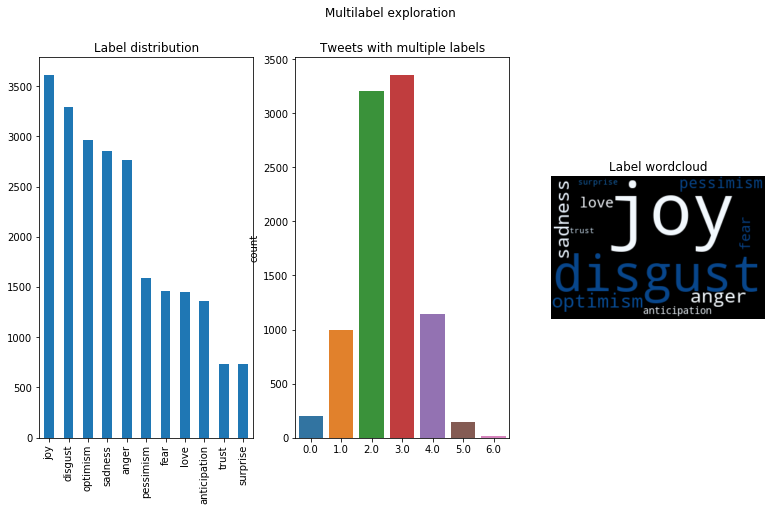

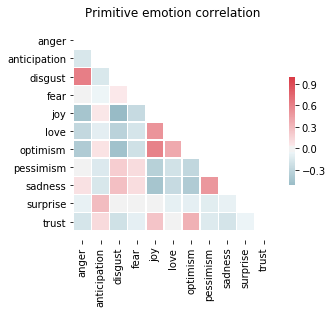

In [59]:
smote_df = pd.DataFrame(y_train, columns=feelings)
mean_irlbls.append(mean_irlbl(smote_df, feelings))
print(mean_irlbls[-1])   
multilabel_visualization(smote_df[feelings].values, feelings)

In [60]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

print("")
print("Starting classifier...")
print("")
start = datetime.now()

pipeline = Pipeline([
                ('clf', OneVsRestClassifier(BernoulliNB(class_prior=None)))
            ])

parameters = [{
            'clf__estimator__alpha': (0.5, 0.7, 1),
            }]

grid_search_cv = GridSearchCV(pipeline, 
                              parameters, 
                              cv=2,
                              verbose=2,
                              n_jobs=-1)
grid_search_cv.fit(x_train, y_train)
best_clf = grid_search_cv.best_estimator_

print('Finished training in : ', datetime.now()-start) 

y_pred = best_clf.predict(x_test)
start = datetime.now()
results = multilabel_evaluation(y_pred, y_test)
addValuesToResults(results)
print(results)
print('Finished classification in : ', datetime.now()-start) 


Starting classifier...

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   15.7s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   15.7s finished


Finished training in :  0:00:24.257851
{'accuracy': 0.833, 'precision': 0.401, 'recall': 0.511, 'f1_score': 0.449, 'hamming_loss': 0.167}
Finished classification in :  0:00:00.007494


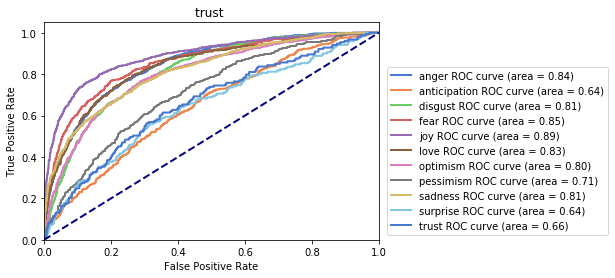

In [61]:
auc_list.append(plot_roc(y_test, best_clf.predict_proba(x_test), feelings.values))

In [62]:
n_emo_clusters, emo_cluster_dict = ideal_partitioning(y_pred, feelings)
n_emo_clusters, emo_cluster_dict

(4,
 {0: Index(['joy', 'love', 'optimism'], dtype='object'),
  1: Index(['anger', 'disgust'], dtype='object'),
  2: Index(['anticipation', 'surprise', 'trust'], dtype='object'),
  3: Index(['fear', 'pessimism', 'sadness'], dtype='object')})

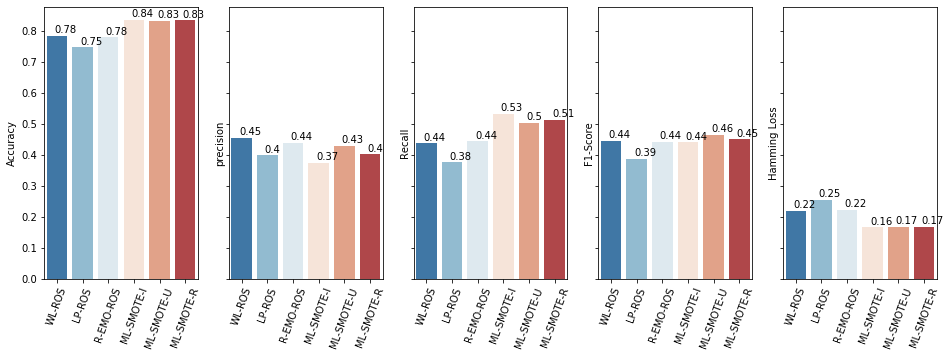

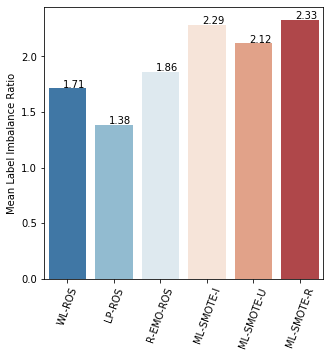

In [64]:
labels = ['WL-ROS', 'LP-ROS', 'R-EMO-ROS', 'ML-SMOTE-I', 'ML-SMOTE-U', 'ML-SMOTE-R']
plotScores(accuracy_res, precision_res, recall_res, f1_res, hamming_res, mean_irlbls[1:], labels)

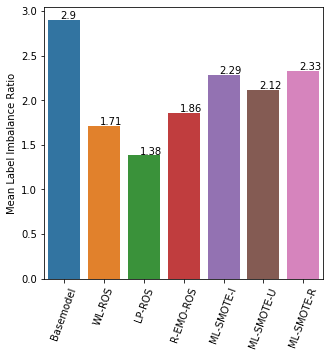

In [65]:
labels = ['Basemodel', 'WL-ROS', 'LP-ROS', 'R-EMO-ROS', 'ML-SMOTE-I', 'ML-SMOTE-U', 'ML-SMOTE-R']

xlabels = list(labels)

fig2, ax = plt.subplots( sharey=True, figsize=(5, 5))
x = np.arange(len(mean_irlbls))
sns.barplot(x, mean_irlbls,  ax=ax)
ax.set_ylabel('Mean Label Imbalance Ratio')
ax.set_xticklabels(xlabels, rotation=70)
for i, v in enumerate( mean_irlbls):
   ax.text(i - 0.1, v + 0.01, str(round(v, 2)))
plt.show()


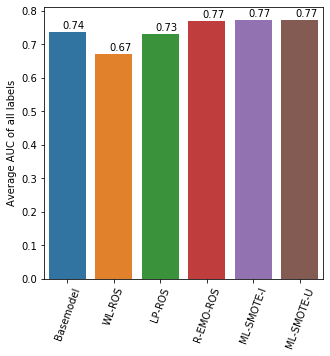

In [66]:
fig2, ax = plt.subplots( sharey=True, figsize=(5, 5))
x = np.arange(len(auc_list))
sns.barplot(x, auc_list,  ax=ax)
ax.set_ylabel('Average AUC of all labels')
ax.set_xticklabels(xlabels, rotation=70)
for i, v in enumerate( auc_list):
   ax.text(i - 0.1, v + 0.01, str(round(v, 2)))
plt.show()